## Import all the necessary libraries

In [60]:
# ! pip install dataprep 
# ! pip install xgboost
# ! pip install imbalanced-learn
# ! pip install pyathena

In [121]:
import pandas as pd
from sklearn import preprocessing
from dataprep.eda import create_report, plot_correlation
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn import metrics
from sklearn import tree
import os
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
import boto3
import sagemaker
from pyathena import connect
import time
from time import gmtime, strftime, sleep
from sagemaker.session import Session
from sagemaker import get_execution_role
from sagemaker.feature_store.feature_group import FeatureGroup
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
import re
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

## Data

For this project, we have exploited the dataset “Indicators of Heart Disease (2022 UPDATE)”, which is available on Kaggle (https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease).

## EDA and Data Preparation

In [4]:
# Use the datafile "heart_2020_cleaned.csv" from (https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease

df1 = pd.read_csv('heart_2020_cleaned.csv') # access and read the datafile
df2 = pd.read_csv('heart_2022_no_nans.csv') # access and read the datafile

print('The shape of dataset df1 is', df1.shape, '\n') # print the shape of df1

print('The shape of dataset df2 is', df2.shape, '\n') # print the shape of df2

print('Features dataset df1:', df1.columns, '\n')
print('Features dataset df2:', df2.columns, '\n')

The shape of dataset df1 is (319795, 18) 

The shape of dataset df2 is (246022, 40) 

Features dataset df1: Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object') 

Features dataset df2: Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthni

In [5]:
# df2 is adjusted based on df1
df2_bis = pd.DataFrame({'HeartDisease': df2.HighRiskLastYear,
                       'BMI': df2.BMI,
                       'Smoking': df2.SmokerStatus,
                       'AlcoholDrinking': df2.AlcoholDrinkers,
                       'Stroke': df2.HadStroke,
                       'PhysicalHealth': df2.PhysicalHealthDays,
                       'MentalHealth': df2.MentalHealthDays,
                       'DiffWalking': df2.DifficultyWalking,
                       'Sex': df2.Sex,
                       'AgeCategory': df2.AgeCategory,
                       'Race': df2.RaceEthnicityCategory,
                       'Diabetic': df2.HadDiabetes,
                       'PhysicalActivity': df2.PhysicalActivities,
                       'GenHealth': df2.GeneralHealth,
                       'SleepTime': df2.SleepHours,
                       'Asthma': df2.HadAsthma,
                       'KidneyDisease': df2.HadKidneyDisease,
                       'SkinCancer': df2.HadSkinCancer})

In [6]:
# Print the first rows of df1 to understand if further adjustments are necessary
print('First rows of df1: \n') # print the first rows of df1
df1

First rows of df1: 



,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


In [7]:
# Print the first rows of df2_bis to understand if further adjustments are necessary
print('First rows of df2_bis: \n') # print the first rows of df2
df2_bis

First rows of df2_bis: 



,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,27.99,Former smoker,No,No,4.0,0.0,No,Female,Age 65 to 69,"White only, Non-Hispanic",No,Yes,Very good,9.0,No,No,No
1,No,30.13,Former smoker,No,No,0.0,0.0,No,Male,Age 70 to 74,"White only, Non-Hispanic",Yes,Yes,Very good,6.0,No,No,No
2,No,31.66,Former smoker,Yes,No,0.0,0.0,Yes,Male,Age 75 to 79,"White only, Non-Hispanic",No,No,Very good,8.0,No,No,No
3,No,31.32,Never smoked,No,No,5.0,0.0,Yes,Female,Age 80 or older,"White only, Non-Hispanic",No,Yes,Fair,9.0,No,No,Yes
4,No,33.07,Never smoked,No,No,3.0,15.0,No,Female,Age 80 or older,"White only, Non-Hispanic",No,Yes,Good,5.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246017,No,32.28,Never smoked,Yes,No,0.0,0.0,No,Male,Age 60 to 64,"White only, Non-Hispanic",No,Yes,Very good,6.0,No,No,No
246018,No,24.34,Never smoked,No,No,0.0,7.0,No,Female,Age 25 to 29,"Black only, Non-Hispanic",No,Yes,Fair,7.0,No,No,No
246019,No,29.86,Never smoked,Yes,Yes,0.0,15.0,No,Male,Age 65 to 69,"Multiracial, Non-Hispanic",Yes,Yes,Good,7.0,No,No,No
246020,No,28.66,Never smoked,No,No,2.0,2.0,No,Female,Age 50 to 54,"Black only, Non-Hispanic",No,Yes,Excellent,7.0,No,No,No


In [8]:
# Uniform df1 and df2_bis

# print('Entries of column "Smoking" in df2_bis dataset: \n', df2_bis.Smoking.unique())
df2_bis.loc[df2_bis.Smoking == 'Former smoker', 'Smoking'] = 'No'
df2_bis.loc[df2_bis.Smoking == 'Never smoked', 'Smoking'] = 'No'
df2_bis.loc[df2_bis.Smoking == 'Current smoker - now smokes every day', 'Smoking'] = 'Yes'
df2_bis.loc[df2_bis.Smoking == 'Current smoker - now smokes some days', 'Smoking'] = 'Yes'

# print('Entries of column "AgeCategory" in df2_bis dataset: \n', df2_bis.AgeCategory.unique())
df2_bis.loc[df2_bis.AgeCategory == 'Age 18 to 24', 'AgeCategory'] = '18-24'
df2_bis.loc[df2_bis.AgeCategory == 'Age 25 to 29', 'AgeCategory'] = '25-29'
df2_bis.loc[df2_bis.AgeCategory == 'Age 30 to 34', 'AgeCategory'] = '30-34'
df2_bis.loc[df2_bis.AgeCategory == 'Age 35 to 39', 'AgeCategory'] = '35-39'
df2_bis.loc[df2_bis.AgeCategory == 'Age 40 to 44', 'AgeCategory'] = '40-44'
df2_bis.loc[df2_bis.AgeCategory == 'Age 45 to 49', 'AgeCategory'] = '45-49'
df2_bis.loc[df2_bis.AgeCategory == 'Age 50 to 54', 'AgeCategory'] = '50-54'
df2_bis.loc[df2_bis.AgeCategory == 'Age 55 to 59', 'AgeCategory'] = '55-59'
df2_bis.loc[df2_bis.AgeCategory == 'Age 60 to 64', 'AgeCategory'] = '60-64'
df2_bis.loc[df2_bis.AgeCategory == 'Age 65 to 69', 'AgeCategory'] = '65-69'
df2_bis.loc[df2_bis.AgeCategory == 'Age 70 to 74', 'AgeCategory'] = '70-74'
df2_bis.loc[df2_bis.AgeCategory == 'Age 75 to 79', 'AgeCategory'] = '75-79'
df2_bis.loc[df2_bis.AgeCategory == 'Age 80 or older', 'AgeCategory'] = '80 or older'

# print('Entries of column "Race" in df2_bis dataset: \n', df2_bis.Race.unique())
df2_bis.loc[df2_bis.Race == 'White only, Non-Hispanic', 'Race'] = 'White'
df2_bis.loc[df2_bis.Race == 'Black only, Non-Hispanic', 'Race'] = 'Black'
df2_bis.loc[df2_bis.Race == 'Multiracial, Non-Hispanic', 'Race'] = 'Multiracial'
df2_bis.loc[df2_bis.Race == 'Other race only, Non-Hispanic', 'Race'] = 'Other'
df1.loc[df1.Race == 'Asian', 'Race'] = 'Multiracial'
df1.loc[df1.Race == 'American Indian/Alaskan Native', 'Race'] = 'Multiracial'

We initially trained the model on the data collected in 2020 only, which are in dataset df1. 

## Feature Engineering

In [9]:
# Convert categorical to numerical features

def cat_to_num(dataset):
    
    # Binary features
    dataset.HeartDisease.replace(('No', 'Yes'), (0, 1), inplace = True)
    dataset.Smoking.replace(('No', 'Yes'), (0, 1), inplace = True)
    dataset.AlcoholDrinking.replace(('No', 'Yes'), (0, 1), inplace = True)
    dataset.Stroke.replace(('No', 'Yes'), (0, 1), inplace = True)
    dataset.DiffWalking.replace(('No', 'Yes'), (0, 1), inplace = True)
    dataset.Sex.replace(('Female', 'Male'), (0, 1), inplace = True)
    dataset.PhysicalActivity.replace(('No', 'Yes'), (0, 1), inplace = True)
    dataset.Asthma.replace(('No', 'Yes'), (0, 1), inplace = True)
    dataset.KidneyDisease.replace(('No', 'Yes'), (0, 1), inplace = True)
    dataset.SkinCancer.replace(('No', 'Yes'), (0, 1), inplace = True)
    # Not binary features
    label_encoder = preprocessing.LabelEncoder()
    dataset.AgeCategory = label_encoder.fit_transform(dataset.AgeCategory)
    dataset.Race = label_encoder.fit_transform(dataset.Race)
    dataset.Diabetic = label_encoder.fit_transform(dataset.Diabetic)
    dataset.GenHealth = label_encoder.fit_transform(dataset.GenHealth)

    return dataset

df1 = cat_to_num(df1)
df2_bis = cat_to_num(df2_bis)

## Create S3 bucket

In [10]:
session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

s3 = sagemaker_session.boto_session.resource("s3")

## Upload df1 and df2_bis to S3

In [11]:
df1.to_csv('results_2020.csv', sep = ",", index = False)
df2_bis.to_csv('results_2022.csv', sep = ",", index = False)

In [12]:
filename1 = 'results_2020.csv'
prefix1 = os.path.basename(filename1)
filename_key1 = filename1.split(".")[0]
s3.Bucket(bucket).upload_file(filename1, "{}/{}/{}".format(prefix1, filename_key1, filename1))

filename2 = 'results_2022.csv'
prefix2 = os.path.basename(filename2)
filename_key2 = filename2.split(".")[0]
s3.Bucket(bucket).upload_file(filename2, "{}/{}/{}".format(prefix2, filename_key2, filename2))

## Create Athena databases for df1 and df2_bis

In [13]:
databasename_csv1 = "tabular_results_2020"
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
conn = connect(region_name = region, s3_staging_dir = s3_staging_dir)
statement1 = "CREATE DATABASE IF NOT EXISTS {}".format(databasename_csv1)
print(statement1)

databasename_csv2 = "tabular_results_2022"
statement2 = "CREATE DATABASE IF NOT EXISTS {}".format(databasename_csv2)
print(statement2)

CREATE DATABASE IF NOT EXISTS tabular_results_2020
CREATE DATABASE IF NOT EXISTS tabular_results_2022


In [14]:
pd.read_sql(statement1, conn)
pd.read_sql(statement2, conn)

/tmp/ipykernel_18/3834315950.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement1, conn)
/tmp/ipykernel_18/3834315950.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement2, conn)


""


## Verify the databases for df1 and df2_bis have been created succesfully

In [15]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show

/tmp/ipykernel_18/2126029005.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,database_name
0,default
1,sagemaker_featurestore
2,tabular_data_2020
3,tabular_dataset_2020
4,tabular_df_2020
5,tabular_results_2020
6,tabular_results_2022


## Register tables with Athena for df1 and df2_bis

In [16]:
databasename_csv1 = "tabular_results_2020"
tablename_csv1 = "results_csv_2020"
data_s3_location1 = "s3://{}/{}/{}/".format(bucket, prefix1, filename_key1)

statement1 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         HeartDisease int,
         BMI float,
         Smoking int,
         AlcoholDrinking int,
         Stroke int,
         PhysicalHealth float,
         MentalHealth float,
         DiffWalking int,
         Sex int,
         AgeCategory int,
         Race int,
         Diabetic int,
         PhysicalActivity int,
         GenHealth int,
         SleepTime float,
         Asthma int,
         KidneyDisease int,
         SkinCancer int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    databasename_csv1, tablename_csv1, data_s3_location1
)

print(statement1)

CREATE EXTERNAL TABLE IF NOT EXISTS tabular_results_2020.results_csv_2020(
         HeartDisease int,
         BMI float,
         Smoking int,
         AlcoholDrinking int,
         Stroke int,
         PhysicalHealth float,
         MentalHealth float,
         DiffWalking int,
         Sex int,
         AgeCategory int,
         Race int,
         Diabetic int,
         PhysicalActivity int,
         GenHealth int,
         SleepTime float,
         Asthma int,
         KidneyDisease int,
         SkinCancer int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\n' LOCATION 's3://sagemaker-us-east-1-917612120297/results_2020.csv/results_2020/'
TBLPROPERTIES ('skip.header.line.count'='1')


In [17]:
pd.read_sql(statement1, conn)

/tmp/ipykernel_18/2913604131.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement1, conn)


""


In [18]:
databasename_csv2 = "tabular_results_2022"
tablename_csv2 = "results_csv_2022"
data_s3_location2 = "s3://{}/{}/{}/".format(bucket, prefix2, filename_key2)

statement2 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         HeartDisease int,
         BMI float,
         Smoking int,
         AlcoholDrinking int,
         Stroke int,
         PhysicalHealth float,
         MentalHealth float,
         DiffWalking int,
         Sex int,
         AgeCategory int,
         Race int,
         Diabetic int,
         PhysicalActivity int,
         GenHealth int,
         SleepTime float,
         Asthma int,
         KidneyDisease int,
         SkinCancer int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    databasename_csv2, tablename_csv2, data_s3_location2
)

print(statement2)

CREATE EXTERNAL TABLE IF NOT EXISTS tabular_results_2022.results_csv_2022(
         HeartDisease int,
         BMI float,
         Smoking int,
         AlcoholDrinking int,
         Stroke int,
         PhysicalHealth float,
         MentalHealth float,
         DiffWalking int,
         Sex int,
         AgeCategory int,
         Race int,
         Diabetic int,
         PhysicalActivity int,
         GenHealth int,
         SleepTime float,
         Asthma int,
         KidneyDisease int,
         SkinCancer int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\n' LOCATION 's3://sagemaker-us-east-1-917612120297/results_2022.csv/results_2022/'
TBLPROPERTIES ('skip.header.line.count'='1')


In [19]:
pd.read_sql(statement2, conn)

/tmp/ipykernel_18/2428764963.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement2, conn)


""


## Verify the tables for df1 and df2_bis have been created succesfully

In [20]:
statement1 = "SHOW TABLES in {}".format(databasename_csv1)

df_show1 = pd.read_sql(statement1, conn)
df_show1

/tmp/ipykernel_18/1951954014.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show1 = pd.read_sql(statement1, conn)


,tab_name
0,results_csv_2020


In [21]:
statement2 = "SHOW TABLES in {}".format(databasename_csv2)

df_show2 = pd.read_sql(statement2, conn)
df_show2

/tmp/ipykernel_18/3956172068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show2 = pd.read_sql(statement2, conn)


,tab_name
0,results_csv_2022


## Run sample query for df1

In [22]:
statement1 = """SELECT * FROM {}.{}""".format(
    databasename_csv1, tablename_csv1
)

print(statement1)

SELECT * FROM tabular_results_2020.results_csv_2020


In [23]:
df1 = pd.read_sql(statement1, conn)
df1.head(5)

/tmp/ipykernel_18/328453732.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql(statement1, conn)


,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer
0,0,16.60,1,0,0,3.0,30.0,0,0,7,4,2,1,4,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,12,4,0,1,4,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,1,9,4,2,1,1,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,11,4,0,0,2,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,0,4,4,0,1,4,8.0,0,0,0


## Run sample query for df2_bis

In [24]:
statement2 = """SELECT * FROM {}.{}""".format(
    databasename_csv2, tablename_csv2
)

print(statement2)

SELECT * FROM tabular_results_2022.results_csv_2022


In [25]:
df2_bis = pd.read_sql(statement2, conn)
df2_bis.head(5)

/tmp/ipykernel_18/3919110687.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2_bis = pd.read_sql(statement2, conn)


,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer
0,0,27.99,0,0,0,4.0,0.0,0,0,9,4,0,1,4,9.0,0,0,0
1,0,30.13,0,0,0,0.0,0.0,0,1,10,4,2,1,4,6.0,0,0,0
2,0,31.66,0,1,0,0.0,0.0,1,1,11,4,0,0,4,8.0,0,0,0
3,0,31.32,0,0,0,5.0,0.0,1,0,12,4,0,1,1,9.0,0,0,1
4,0,33.07,0,0,0,3.0,15.0,0,0,12,4,0,1,2,5.0,0,0,0


## Additional checks on df1 and df2_bis

In [26]:
# Number of NaN values for each column in df1
print('Number of NaN values for each column of the df1 dataset:') 
print(df1.isna().sum(), '\n\n')
 
# Number of NaN values for each column in df2_bis
print('Number of NaN values for each column of the df2_bis dataset:') 
print(df2_bis.isna().sum(), '\n\n')

Number of NaN values for each column of the df1 dataset:
heartdisease        0
bmi                 0
smoking             0
alcoholdrinking     0
stroke              0
physicalhealth      0
mentalhealth        0
diffwalking         0
sex                 0
agecategory         0
race                0
diabetic            0
physicalactivity    0
genhealth           0
sleeptime           0
asthma              0
kidneydisease       0
skincancer          0
dtype: int64 


Number of NaN values for each column of the df2_bis dataset:
heartdisease        0
bmi                 0
smoking             0
alcoholdrinking     0
stroke              0
physicalhealth      0
mentalhealth        0
diffwalking         0
sex                 0
agecategory         0
race                0
diabetic            0
physicalactivity    0
genhealth           0
sleeptime           0
asthma              0
kidneydisease       0
skincancer          0
dtype: int64 




## Ingest data df1 and df2_bis into FeatureStore

In [27]:
region = boto3.Session().region_name

boto_session = boto3.Session(region_name = region)

sagemaker_client = boto_session.client(service_name = 'sagemaker', region_name = region)
featurestore_runtime = boto_session.client(
    service_name = 'sagemaker-featurestore-runtime', region_name = region
)

feature_store_session = Session(
    boto_session = boto_session,
    sagemaker_client = sagemaker_client,
    sagemaker_featurestore_runtime_client = featurestore_runtime,
)

default_s3_bucket_name = feature_store_session.default_bucket()
prefix = 'sagemaker-featurestore-heart-project'
role = get_execution_role()

## Define the FeatureGroups

In [28]:
data_2020_feature_group_name = 'data-2020-feature-group-' + strftime('%d-%H-%M-%S', gmtime())
data_2022_feature_group_name = 'data-2022-feature-group-' + strftime('%d-%H-%M-%S', gmtime())

In [29]:
data_2020_feature_group = FeatureGroup(
    name = data_2020_feature_group_name, sagemaker_session = feature_store_session
)
data_2022_feature_group = FeatureGroup(
    name = data_2022_feature_group_name, sagemaker_session = feature_store_session
)

In [30]:
current_time_sec = int(round(time.time()))

def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == 'object':
            data_frame[label] = data_frame[label].astype('str').astype('string')

# Cast object dtype to string. The SageMaker FeatureStore Python SDK will then map the string dtype to String feature type
cast_object_to_string(df1)
cast_object_to_string(df2_bis)

# Record identifier and event time feature names
record_identifier_feature_name = 'heartdisease'
event_time_feature_name = 'event_time'

# Append EventTime feature
df1[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(df1), dtype = 'float64'
)
df2_bis[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(df2_bis), dtype = 'float64'
)

# Load feature definitions to the feature group. SageMaker FeatureStore Python SDK will auto-detect the data schema based on input data
data_2020_feature_group.load_feature_definitions(data_frame = df1)
# output is suppressed
data_2022_feature_group.load_feature_definitions(data_frame = df2_bis)
# output is suppressed

[FeatureDefinition(feature_name='heartdisease', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='bmi', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='smoking', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='alcoholdrinking', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='stroke', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='physicalhealth', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='mentalhealth', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='diffwalking', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefi

## Create the FeatureGroups in SageMaker FeatureStore

In [31]:
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

data_2020_feature_group.create(
    s3_uri = f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name = record_identifier_feature_name,
    event_time_feature_name = event_time_feature_name,
    role_arn = role,
    enable_online_store = True,
)

data_2022_feature_group.create(
    s3_uri = f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name = record_identifier_feature_name,
    event_time_feature_name = event_time_feature_name,
    role_arn = role,
    enable_online_store = True,
)

wait_for_feature_group_creation_complete(feature_group = data_2020_feature_group)
wait_for_feature_group_creation_complete(feature_group = data_2022_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup data-2020-feature-group-14-13-44-10 successfully created.
Waiting for Feature Group Creation
FeatureGroup data-2022-feature-group-14-13-44-10 successfully created.


In [32]:
data_2020_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:917612120297:feature-group/data-2020-feature-group-14-13-44-10',
 'FeatureGroupName': 'data-2020-feature-group-14-13-44-10',
 'RecordIdentifierFeatureName': 'heartdisease',
 'EventTimeFeatureName': 'event_time',
 'FeatureDefinitions': [{'FeatureName': 'heartdisease',
   'FeatureType': 'Integral'},
  {'FeatureName': 'bmi', 'FeatureType': 'Fractional'},
  {'FeatureName': 'smoking', 'FeatureType': 'Integral'},
  {'FeatureName': 'alcoholdrinking', 'FeatureType': 'Integral'},
  {'FeatureName': 'stroke', 'FeatureType': 'Integral'},
  {'FeatureName': 'physicalhealth', 'FeatureType': 'Fractional'},
  {'FeatureName': 'mentalhealth', 'FeatureType': 'Fractional'},
  {'FeatureName': 'diffwalking', 'FeatureType': 'Integral'},
  {'FeatureName': 'sex', 'FeatureType': 'Integral'},
  {'FeatureName': 'agecategory', 'FeatureType': 'Integral'},
  {'FeatureName': 'race', 'FeatureType': 'Integral'},
  {'FeatureName': 'diabetic', 'FeatureType': 'Integral'},
  

In [33]:
data_2022_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:917612120297:feature-group/data-2022-feature-group-14-13-44-10',
 'FeatureGroupName': 'data-2022-feature-group-14-13-44-10',
 'RecordIdentifierFeatureName': 'heartdisease',
 'EventTimeFeatureName': 'event_time',
 'FeatureDefinitions': [{'FeatureName': 'heartdisease',
   'FeatureType': 'Integral'},
  {'FeatureName': 'bmi', 'FeatureType': 'Fractional'},
  {'FeatureName': 'smoking', 'FeatureType': 'Integral'},
  {'FeatureName': 'alcoholdrinking', 'FeatureType': 'Integral'},
  {'FeatureName': 'stroke', 'FeatureType': 'Integral'},
  {'FeatureName': 'physicalhealth', 'FeatureType': 'Fractional'},
  {'FeatureName': 'mentalhealth', 'FeatureType': 'Fractional'},
  {'FeatureName': 'diffwalking', 'FeatureType': 'Integral'},
  {'FeatureName': 'sex', 'FeatureType': 'Integral'},
  {'FeatureName': 'agecategory', 'FeatureType': 'Integral'},
  {'FeatureName': 'race', 'FeatureType': 'Integral'},
  {'FeatureName': 'diabetic', 'FeatureType': 'Integral'},
  

In [34]:
sagemaker_client.list_feature_groups() 

{'FeatureGroupSummaries': [{'FeatureGroupName': 'data-2022-feature-group-14-13-44-10',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:917612120297:feature-group/data-2022-feature-group-14-13-44-10',
   'CreationTime': datetime.datetime(2024, 6, 14, 13, 44, 12, 710000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created'},
  {'FeatureGroupName': 'data-2022-feature-group-14-10-02-09',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:917612120297:feature-group/data-2022-feature-group-14-10-02-09',
   'CreationTime': datetime.datetime(2024, 6, 14, 10, 13, 53, 354000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created',
   'OfflineStoreStatus': {'Status': 'Active'}},
  {'FeatureGroupName': 'data-2020-feature-group-14-13-44-10',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:917612120297:feature-group/data-2020-feature-group-14-13-44-10',
   'CreationTime': datetime.datetime(2024, 6, 14, 13, 44, 10, 631000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created'},
  {'FeatureGroup

## PutRecords into the FeatureGroups

In [35]:
data_2020_feature_group.ingest(data_frame = df1, max_workers = 3, wait = True)

Started ingesting index 106599 to 213198
Started ingesting index 213198 to 319795
Started ingesting index 0 to 106599
Successfully ingested row 106599 to 213198
Successfully ingested row 0 to 106599
Successfully ingested row 213198 to 319795


IngestionManagerPandas(feature_group_name='data-2020-feature-group-14-13-44-10', feature_definitions={'heartdisease': {'FeatureName': 'heartdisease', 'FeatureType': 'Integral'}, 'bmi': {'FeatureName': 'bmi', 'FeatureType': 'Fractional'}, 'smoking': {'FeatureName': 'smoking', 'FeatureType': 'Integral'}, 'alcoholdrinking': {'FeatureName': 'alcoholdrinking', 'FeatureType': 'Integral'}, 'stroke': {'FeatureName': 'stroke', 'FeatureType': 'Integral'}, 'physicalhealth': {'FeatureName': 'physicalhealth', 'FeatureType': 'Fractional'}, 'mentalhealth': {'FeatureName': 'mentalhealth', 'FeatureType': 'Fractional'}, 'diffwalking': {'FeatureName': 'diffwalking', 'FeatureType': 'Integral'}, 'sex': {'FeatureName': 'sex', 'FeatureType': 'Integral'}, 'agecategory': {'FeatureName': 'agecategory', 'FeatureType': 'Integral'}, 'race': {'FeatureName': 'race', 'FeatureType': 'Integral'}, 'diabetic': {'FeatureName': 'diabetic', 'FeatureType': 'Integral'}, 'physicalactivity': {'FeatureName': 'physicalactivity', 

In [36]:
data_2022_feature_group.ingest(data_frame = df2_bis, max_workers = 3, wait = True)

Started ingesting index 164016 to 246022
Started ingesting index 82008 to 164016
Started ingesting index 0 to 82008
Successfully ingested row 164016 to 246022
Successfully ingested row 0 to 82008
Successfully ingested row 82008 to 164016


IngestionManagerPandas(feature_group_name='data-2022-feature-group-14-13-44-10', feature_definitions={'heartdisease': {'FeatureName': 'heartdisease', 'FeatureType': 'Integral'}, 'bmi': {'FeatureName': 'bmi', 'FeatureType': 'Fractional'}, 'smoking': {'FeatureName': 'smoking', 'FeatureType': 'Integral'}, 'alcoholdrinking': {'FeatureName': 'alcoholdrinking', 'FeatureType': 'Integral'}, 'stroke': {'FeatureName': 'stroke', 'FeatureType': 'Integral'}, 'physicalhealth': {'FeatureName': 'physicalhealth', 'FeatureType': 'Fractional'}, 'mentalhealth': {'FeatureName': 'mentalhealth', 'FeatureType': 'Fractional'}, 'diffwalking': {'FeatureName': 'diffwalking', 'FeatureType': 'Integral'}, 'sex': {'FeatureName': 'sex', 'FeatureType': 'Integral'}, 'agecategory': {'FeatureName': 'agecategory', 'FeatureType': 'Integral'}, 'race': {'FeatureName': 'race', 'FeatureType': 'Integral'}, 'diabetic': {'FeatureName': 'diabetic', 'FeatureType': 'Integral'}, 'physicalactivity': {'FeatureName': 'physicalactivity', 

In [37]:
data_2020_feature_group_resolved_output_s3_uri = (
    data_2020_feature_group.describe()
    .get('OfflineStoreConfig')
    .get('S3StorageConfig')
    .get('ResolvedOutputS3Uri')
)
data_2022_feature_group_resolved_output_s3_uri = (
    data_2022_feature_group.describe()
    .get('OfflineStoreConfig')
    .get('S3StorageConfig')
    .get('ResolvedOutputS3Uri')
)

data_2020_feature_group_s3_prefix = data_2020_feature_group_resolved_output_s3_uri.replace(
    f's3://{default_s3_bucket_name}/', ''
)
data_2022_feature_group_s3_prefix = data_2022_feature_group_resolved_output_s3_uri.replace(
    f's3://{default_s3_bucket_name}/', ''
)

offline_store_contents = None
while offline_store_contents is None:
    objects_in_bucket = boto3.client('s3', region_name = region).list_objects(
        Bucket = default_s3_bucket_name, Prefix = data_2022_feature_group_s3_prefix
    )
    if 'Contents' in objects_in_bucket and len(objects_in_bucket['Contents']) > 1:
        offline_store_contents = objects_in_bucket['Contents']
    else:
        print('Waiting for data in offline store...\n')
        sleep(60)

print('Data available.')

Data available.


## Try to retrieve a portion of df1 and df2_bis datasets from the FeatureStore

In [45]:
data_2020_query = data_2020_feature_group.athena_query()
data_2020_table = data_2020_query.table_name

query_string = (
    'SELECT * FROM "'
    + data_2020_table
    + '"LIMIT 1500'
)
print('Running ' + query_string)

# Run Athena query. The output is loaded to a Pandas dataframe.
# dataset = pd.DataFrame()
data_2020_query.run(
    query_string = query_string,
    output_location = 's3://' + default_s3_bucket_name + '/' + prefix + '/query_results/',
)
data_2020_query.wait()
dataset_2020 = data_2020_query.as_dataframe()

dataset_2020

Query 2c431293-a1e7-433b-a4e3-c249263b1627 is being executed.


Running SELECT * FROM "data_2020_feature_group_14_13_44_10_1718372650"LIMIT 1500


Query 2c431293-a1e7-433b-a4e3-c249263b1627 successfully executed.


,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,...,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer,event_time,write_time,api_invocation_time,is_deleted
0,0,24.03,0,0,0,15.0,0.0,0,0,10,...,1,1,6.0,0,0,0,1.718373e+09,2024-06-14 13:57:40.517,2024-06-14 13:57:23.000,False
1,0,25.09,0,0,0,0.0,4.0,0,0,8,...,1,0,8.0,0,0,1,1.718373e+09,2024-06-14 13:57:40.517,2024-06-14 13:57:23.000,False
2,0,25.77,1,0,0,0.0,1.0,0,1,4,...,1,4,8.0,0,0,0,1.718373e+09,2024-06-14 13:57:40.517,2024-06-14 13:57:23.000,False
3,0,20.98,1,0,0,5.0,1.0,1,0,9,...,1,4,7.0,1,0,1,1.718373e+09,2024-06-14 13:57:40.517,2024-06-14 13:57:23.000,False
4,0,23.49,0,0,0,0.0,0.0,0,0,7,...,1,0,7.0,0,0,1,1.718373e+09,2024-06-14 13:57:40.517,2024-06-14 13:57:23.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,34.18,0,0,0,0.0,0.0,0,0,4,...,1,4,6.0,0,0,0,1.718373e+09,2024-06-14 13:57:56.828,2024-06-14 13:57:42.000,False
1496,0,22.31,0,0,0,0.0,10.0,0,0,1,...,1,0,6.0,0,0,0,1.718373e+09,2024-06-14 13:57:56.828,2024-06-14 13:57:42.000,False
1497,0,29.53,1,0,0,30.0,0.0,0,1,9,...,1,1,6.0,0,0,0,1.718373e+09,2024-06-14 13:57:56.828,2024-06-14 13:57:42.000,False
1498,0,24.11,1,0,0,0.0,0.0,0,1,1,...,1,0,7.0,0,0,0,1.718373e+09,2024-06-14 13:57:56.828,2024-06-14 13:57:42.000,False


In [46]:
data_2022_query = data_2022_feature_group.athena_query()
data_2022_table = data_2022_query.table_name

query_string = (
    'SELECT * FROM "'
    + data_2022_table
    + '"LIMIT 1500'
)
print('Running ' + query_string)

# Run Athena query. The output is loaded to a Pandas dataframe.
# dataset = pd.DataFrame()
data_2022_query.run(
    query_string = query_string,
    output_location = 's3://' + default_s3_bucket_name + '/' + prefix + '/query_results/',
)
data_2022_query.wait()
dataset_2022 = data_2022_query.as_dataframe()

dataset_2022

Query da9ba5d6-2b1d-4220-8840-aa03c60dfb11 is being executed.


Running SELECT * FROM "data_2022_feature_group_14_13_44_10_1718372652"LIMIT 1500


Query da9ba5d6-2b1d-4220-8840-aa03c60dfb11 successfully executed.


,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,...,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer,event_time,write_time,api_invocation_time,is_deleted
0,0,33.91,0,1,0,0.0,0.0,0,1,8,...,1,0,8.0,0,0,0,1.718373e+09,2024-06-14 14:17:12.278,2024-06-14 14:16:54.000,False
1,0,29.09,0,0,1,30.0,0.0,0,1,7,...,1,3,6.0,0,0,0,1.718373e+09,2024-06-14 14:17:12.278,2024-06-14 14:16:54.000,False
2,0,37.12,0,1,0,0.0,0.0,0,0,7,...,1,2,7.0,0,0,0,1.718373e+09,2024-06-14 14:17:12.278,2024-06-14 14:16:53.000,False
3,0,28.80,0,0,0,0.0,0.0,0,1,8,...,1,2,8.0,0,0,0,1.718373e+09,2024-06-14 14:17:12.278,2024-06-14 14:16:54.000,False
4,0,22.46,0,0,1,30.0,0.0,0,0,4,...,1,2,9.0,0,0,0,1.718373e+09,2024-06-14 14:17:12.278,2024-06-14 14:16:54.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,40.90,0,1,0,0.0,4.0,0,0,7,...,1,4,7.0,0,0,0,1.718373e+09,2024-06-14 14:17:12.278,2024-06-14 14:17:02.000,False
1496,0,29.76,0,0,0,0.0,0.0,0,0,8,...,1,0,6.0,0,0,0,1.718373e+09,2024-06-14 14:17:12.278,2024-06-14 14:17:02.000,False
1497,0,25.80,1,0,0,0.0,0.0,0,1,10,...,1,2,7.0,0,0,1,1.718373e+09,2024-06-14 14:17:12.278,2024-06-14 14:17:02.000,False
1498,0,27.55,0,0,0,0.0,0.0,0,0,10,...,1,4,7.0,0,0,0,1.718373e+09,2024-06-14 14:17:12.278,2024-06-14 14:17:02.000,False


## Dataset to train the model

We decided to train the model by using the 2020 data only, in order to reserve the 2022 data for production.

In [92]:
df = df1
df = df.drop(columns = 'event_time')

## Scale float features in df

In [93]:
scaler = MinMaxScaler(feature_range = (0,1))
df[['bmi', 'physicalhealth', 'mentalhealth', 'sleeptime']] = scaler.fit_transform(df[['bmi', 'physicalhealth', 'mentalhealth', 'sleeptime']])
df

,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer
0,0,0.055294,1,0,0,0.100000,1.0,0,0,7,4,2,1,4,0.173913,1,0,1
1,0,0.100447,0,0,1,0.000000,0.0,0,0,12,4,0,1,4,0.260870,0,0,0
2,0,0.175782,1,0,0,0.666667,1.0,0,1,9,4,2,1,1,0.304348,1,0,0
3,0,0.147169,0,0,0,0.000000,0.0,0,0,11,4,0,0,2,0.217391,0,0,1
4,0,0.141132,0,0,0,0.933333,0.0,1,0,4,4,0,1,4,0.304348,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,0.185802,1,0,0,0.233333,0.0,1,1,8,1,2,0,1,0.217391,1,0,0
319791,0,0.215139,1,0,0,0.000000,0.0,0,1,3,1,0,1,4,0.173913,1,0,0
319792,0,0.147531,0,0,0,0.000000,0.0,0,0,5,1,0,1,2,0.217391,0,0,0
319793,0,0.250996,0,0,0,0.000000,0.0,0,0,1,1,0,0,2,0.478261,0,0,0


## Identify the most important features through the chi-square test

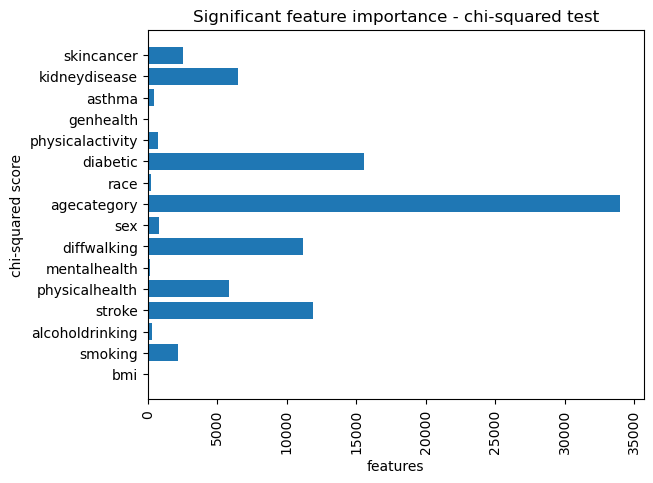

In [94]:
x = df.drop(columns = 'heartdisease')
y = df['heartdisease']
chi_scores, p_values = chi2(x, y)

important_features_chi = np.array(x.columns)[p_values < 0.05]

x_important = x[important_features_chi]

plt.barh(important_features_chi, chi_scores[p_values < 0.05], tick_label = important_features_chi)
plt.title('Significant feature importance - chi-squared test')
plt.xlabel('features')
plt.ylabel('chi-squared score')
plt.xticks(rotation = 90)
plt.savefig('Feature_Importance.jpeg')
plt.show()

In [95]:
print('Important features to consider are:', important_features_chi)

Important features to consider are: ['bmi' 'smoking' 'alcoholdrinking' 'stroke' 'physicalhealth'
 'mentalhealth' 'diffwalking' 'sex' 'agecategory' 'race' 'diabetic'
 'physicalactivity' 'genhealth' 'asthma' 'kidneydisease' 'skincancer']


Based on the results above, we neglected the sleeptime feature while building the model. 

## Check final dataset composition

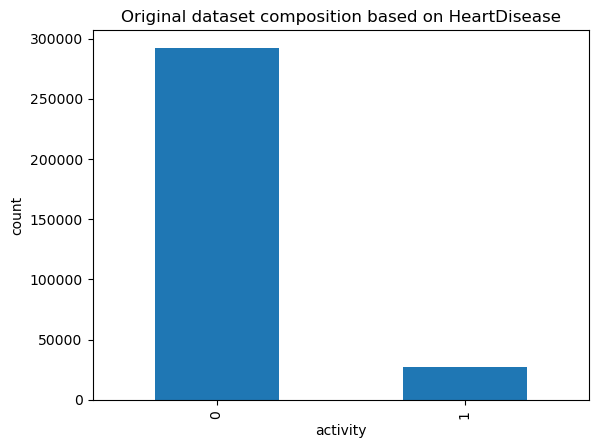

In [96]:
# Check df composition to make sure it is properly balanced
plt.title('Original dataset composition based on HeartDisease')
df['heartdisease'].value_counts().plot.bar()
plt.ylabel('count')
plt.xlabel('activity')
plt.savefig('HD_Composition.jpeg')
plt.show()

The dataset is highly unbalanced with the majority of the available data referring to people with no heart disease. Since the aim of this project is to develop a model able to predict the risk of being affected by heart disease or not based on the other available features, we balanced the dataset. To do that, we first oversampled the minority class (people with no heart disease) through SMOTE and then randomly selected an equal number of readings associated to people with and without heart disease. 

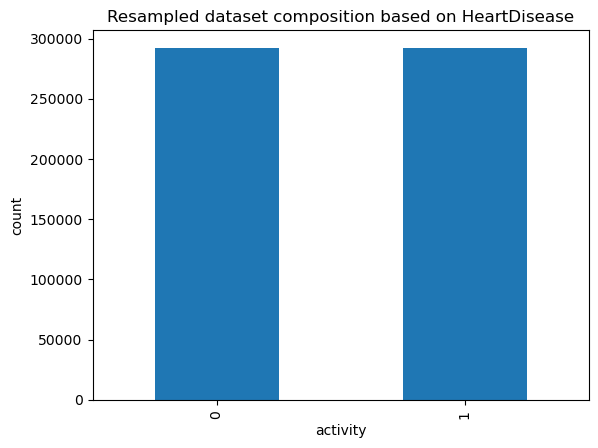

In [97]:
# SMOTE on df
smote = SMOTE(random_state = 42)
x_res, y_res = smote.fit_resample(x, y)

plt.title('Resampled dataset composition based on HeartDisease')
y_res.value_counts().plot.bar()
plt.ylabel('count')
plt.xlabel('activity')
plt.savefig('HD_Composition_Resampled.jpeg')
plt.show()

# Remove the sleeptime feature from x_resampled based on the chi-squared test results

In [98]:
x_final = x_res[important_features_chi]
y_final = y_res
data_final = pd.concat([y_final, x_final], axis = 1)
data_final

,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,asthma,kidneydisease,skincancer
0,0,0.055294,1,0,0,0.100000,1.00000,0,0,7,4,2,1,4,1,0,1
1,0,0.100447,0,0,1,0.000000,0.00000,0,0,12,4,0,1,4,0,0,0
2,0,0.175782,1,0,0,0.666667,1.00000,0,1,9,4,2,1,1,1,0,0
3,0,0.147169,0,0,0,0.000000,0.00000,0,0,11,4,0,0,2,0,0,1
4,0,0.141132,0,0,0,0.933333,0.00000,1,0,4,4,0,1,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584839,1,0.138515,0,0,0,0.000000,0.00000,0,1,12,2,2,1,2,0,0,0
584840,1,0.190646,0,0,0,0.000000,0.00000,0,1,11,4,0,1,4,0,0,0
584841,1,0.296320,0,0,0,0.670599,0.00000,1,0,10,4,0,0,1,1,0,0
584842,1,0.164796,0,0,0,0.000000,0.23786,0,0,5,1,0,1,4,0,0,0


## Data split in three sets, training, validation and batch inference

In [99]:
rand_split = np.random.rand(len(data_final))
train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.9)
batch_list = rand_split >= 0.9

data_train = data_final[train_list]
data_val = data_final[val_list]
data_batch = data_final[batch_list].drop(["heartdisease"], axis = 1)

In [112]:
role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name

bucket = sess.default_bucket()
prefix = "heart-disease-prediction-xgboost"
s3 = boto3.client("s3")

In [101]:
train_file = "train_data.csv"
data_train.to_csv(train_file, index = False, header = False)
sess.upload_data(train_file, key_prefix = "{}/train".format(prefix))

validation_file = "validation_data.csv"
data_val.to_csv(validation_file, index = False, header = False)
sess.upload_data(validation_file, key_prefix = "{}/validation".format(prefix))

batch_file = "batch_data.csv"
data_batch.to_csv(batch_file, index = False, header = False)
sess.upload_data(batch_file, key_prefix = "{}/batch".format(prefix))

's3://sagemaker-us-east-1-917612120297/heart-disease-prediction-xgboost/batch/batch_data.csv'

In [102]:
%%time
from time import gmtime, strftime

job_name = "xgb-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_location = "s3://{}/{}/output/{}".format(bucket, prefix, job_name)
image = sagemaker.image_uris.retrieve(
    framework = "xgboost", region = boto3.Session().region_name, version = "1.7-1"
)

sm_estimator = sagemaker.estimator.Estimator(
    image,
    role,
    instance_count = 1,
    instance_type = "ml.m5.xlarge",
    volume_size = 50,
    input_mode = "File",
    output_path = output_location,
    sagemaker_session = sess,
)

sm_estimator.set_hyperparameters(
    objective = "binary:logistic",
    max_depth = 6,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.8,
    verbosity = 0,
    num_round = 100,
)

train_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train".format(bucket, prefix),
    distribution = "FullyReplicated",
    content_type = "text/csv",
    s3_data_type = "S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validation".format(bucket, prefix),
    distribution = "FullyReplicated",
    content_type = "text/csv",
    s3_data_type = "S3Prefix",
)
data_channels = {"train": train_data, "validation": validation_data}

# Start training by calling the fit method in the estimator
sm_estimator.fit(inputs = data_channels, job_name = job_name, logs = True)

Ignoring unnecessary instance type: None.
Creating training-job with name: xgb-2024-06-14-15-53-06


2024-06-14 15:53:06 Starting - Starting the training job...
2024-06-14 15:53:23 Starting - Preparing the instances for training...
2024-06-14 15:53:54 Downloading - Downloading input data...
2024-06-14 15:54:29 Downloading - Downloading the training image...
2024-06-14 15:54:59 Training - Training image download completed. Training in progress....[2024-06-14 15:55:09.330 ip-10-2-102-29.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-06-14 15:55:09.351 ip-10-2-102-29.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-06-14:15:55:09:INFO] Imported framework sagemaker_xgboost_container.training
[2024-06-14:15:55:09:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2024-06-14:15:55:09:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-14:15:55:09:INFO] Running XGBoost Sagemaker in algorithm mode
[2024-06-14:15:55:09:INFO] Determined 0 GPU(s) available on the insta

## Batch transform

In [105]:
%%time

sm_transformer = sm_estimator.transformer(1, "ml.m4.xlarge")

# Start a transform job
input_location = "s3://{}/{}/batch/{}".format(
    bucket, prefix, batch_file
)  # Use input data without ID column
sm_transformer.transform(input_location, content_type = "text/csv", split_type = "Line")
sm_transformer.wait()

Creating model with name: sagemaker-xgboost-2024-06-14-16-03-25-620
Creating transform job with name: sagemaker-xgboost-2024-06-14-16-03-26-383


..........................................
[2024-06-14:16:10:28:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-14:16:10:28:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-14:16:10:28:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-06-14 16:10:28 +0000] [19] [INFO] S

In [110]:
def get_csv_output_from_s3(s3uri, batch_file):
    file_name = "{}.out".format(batch_file)
    match = re.match("s3://([^/]+)/(.*)", "{}/{}".format(s3uri, file_name))
    output_bucket, output_prefix = match.group(1), match.group(2)
    s3.download_file(output_bucket, output_prefix, file_name)
    return pd.read_csv(file_name, sep = ",", header = None)

## Model results

In [117]:
predictions = get_csv_output_from_s3(sm_transformer.output_path, batch_file)
predicted = list(map(lambda x: 0 if x else 1, (predictions < 0.5).values))
true = data_final[batch_list]['heartdisease'].tolist()

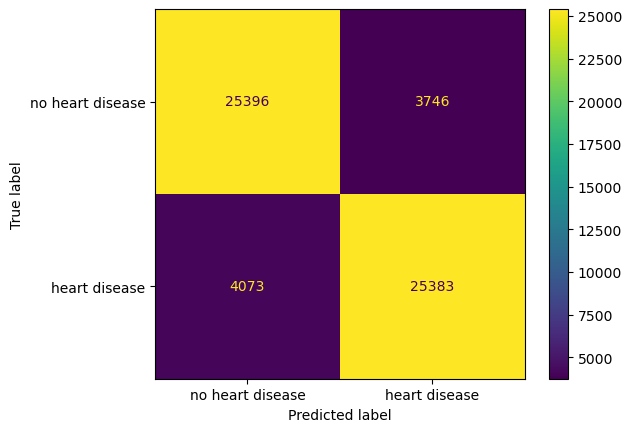

In [122]:
# Confusion Matrix
cm = confusion_matrix(true, predicted)
cm_image = ConfusionMatrixDisplay(cm, display_labels = ['no heart disease', 'heart disease'])
cm_image.plot()

In [123]:
# Classification report
cr = classification_report(true, predicted)
print(cr)

              precision    recall  f1-score   support

           0       0.86      0.87      0.87     29142
           1       0.87      0.86      0.87     29456

    accuracy                           0.87     58598
   macro avg       0.87      0.87      0.87     58598
weighted avg       0.87      0.87      0.87     58598



In [126]:
# ROC AUC
roc_auc = roc_auc_score(true, predictions)
print('ROC-AUC score:', roc_auc)

ROC-AUC score: 0.9455397742491196
